# OCR segmentation flow

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
from sklearn.datasets import make_blobs
from PIL import Image

<IPython.core.display.Javascript object>


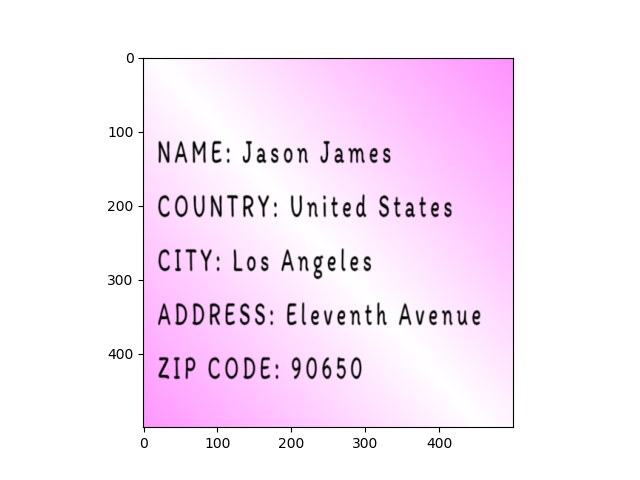

(500, 500)


<IPython.core.display.Javascript object>


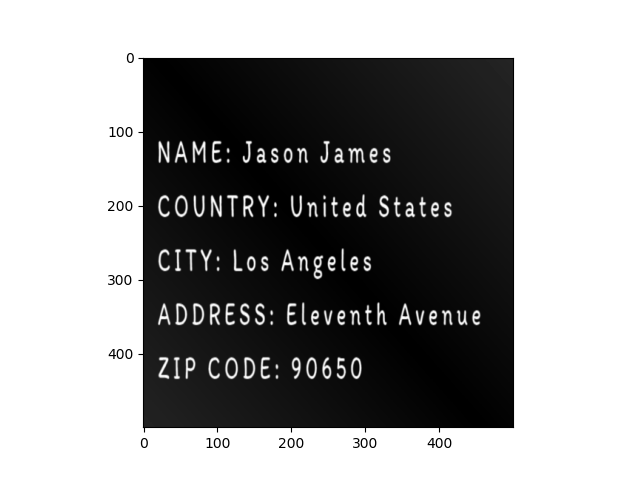

In [27]:
img = np.asarray(Image.open('../imgs/chars/labels/etiqueta1.png'), dtype=np.uint32)
img = Image.open('../imgs/experiments/segmentation/b1.png')
img = img.resize((500, 500))
img = np.asarray(img, dtype=np.uint32)
#img = np.asarray(Image.open('../imgs/photos/1.png'), dtype=np.uint32)

plt.figure()
plt.imshow(img)
plt.savefig("../imgs/results/crop_b1.png")
plt.show()

img = np.mean(img, axis=2)
img = 255 - img
print(img.shape)
plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

## Light correction

### Method 1: Opening residue

<IPython.core.display.Javascript object>


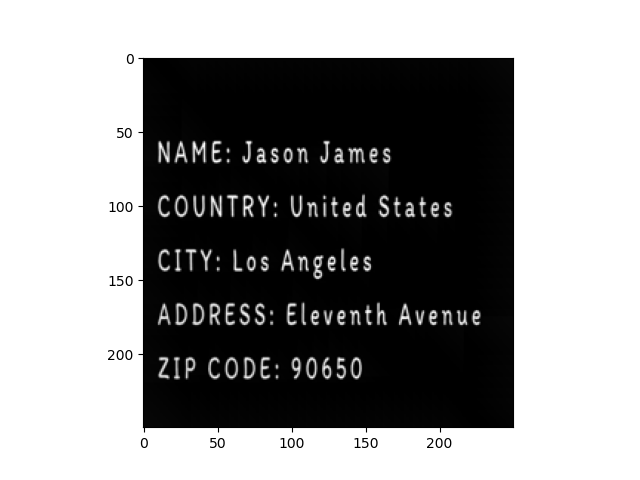

In [10]:
import Mathematical_Morphology as morpho

img_op_res = morpho.openingResidue(img, 50, 50)

plt.figure()
plt.imshow(img_op_res, cmap='gray', vmin=0, vmax=255)
plt.show()

#### Binarization:

##### Manually setting threshold:

<IPython.core.display.Javascript object>


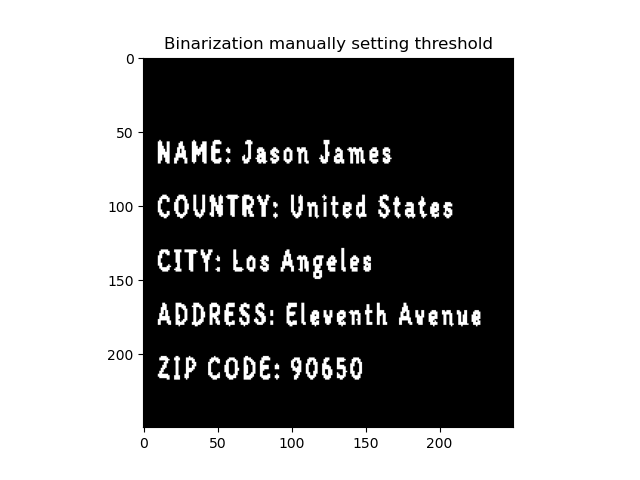

In [26]:
img_op_res_bin = img_op_res.copy()
img_op_res_bin[img_op_res_bin <= 30] = 0
img_op_res_bin[img_op_res_bin > 30] = 1

plt.figure()
plt.imshow(img_op_res_bin, cmap='gray', vmin=0, vmax=1)
plt.title("Binarization manually setting threshold")
plt.savefig("../imgs/results/b1_manualbin.png")
plt.show()

The threshold will be different depending on the type of the letter font, so we use Mean shift to determine the local maximums of the probability density to be able to binarize keeping only the center of the letters.


##### Using Mean shift to segment the text

In [12]:
import MeanShift as MeanShift

X = img_op_res.reshape(-1, 1)
print(X.shape)
finalPoints = MeanShift.MeanShift(X, h=10)

(62500, 1)


In [13]:
clusterColors = {}
colores = []
cm = list(map(str, finalPoints))
quantities = {}

for c in cm:
    if c in clusterColors:
        colores.append(clusterColors[c])
        quantities[c] = quantities[c] + 1
    else:
        newColor = np.random.default_rng().uniform(0,255,3).astype(np.uint8)
        clusterColors[c] = newColor
        quantities[c] = 1
        colores.append(clusterColors[c])
        
        
print("Number of clusters generated: " + str(len(clusterColors)))

Number of clusters generated: 129


In [14]:
maxQ = 0
maxQVal = 0
minQ = 10
minQVal = []

imagen_clusterizada = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint32)
asignaciones2 = np.round(finalPoints.reshape(img.shape[0], img.shape[1]), 5)

for k,v in clusterColors.items():
    imagen_clusterizada[asignaciones2==round(float(k[1:-1]), 5)] = v
    
    if quantities[k] > maxQ:
        maxQ = quantities[k]
        maxQVal = v
        
    if quantities[k] < minQ:
        minQVal.append(v)

<IPython.core.display.Javascript object>


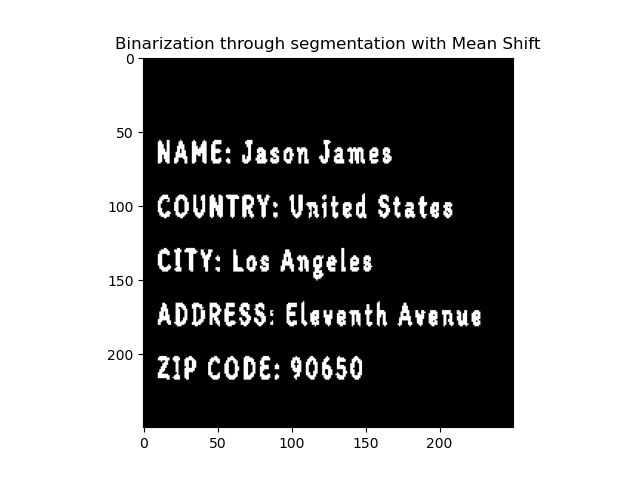

In [25]:
image_letters = np.where(imagen_clusterizada!=maxQVal, 1, 0)

for mv in minQVal:
    image_letters = np.where(imagen_clusterizada!=mv, image_letters, 0)

image_letters = image_letters[:, :, 0]
plt.figure()
plt.imshow(image_letters, cmap='gray', vmin=0, vmax=1)
plt.title("Binarization through segmentation with Mean Shift")
plt.savefig("../imgs/results/b1_meanshiftbin.png")
plt.show()

### Method 2: Niblack method

<IPython.core.display.Javascript object>


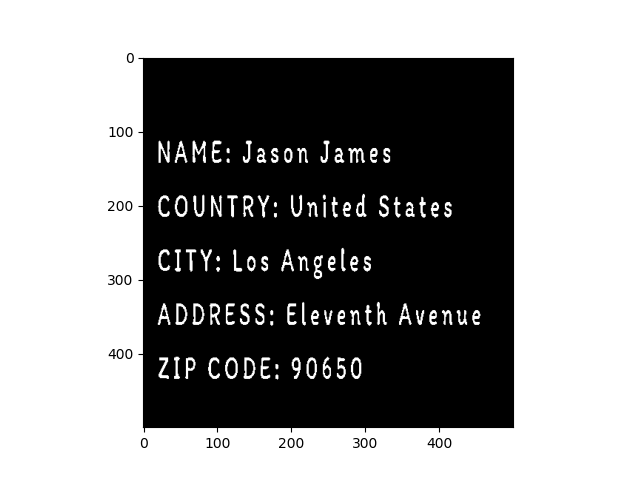

In [28]:
import Niblack as niblack

image_letters = niblack.NiblackBinarization(img, 20, 20, 0.5)

plt.figure()
plt.imshow(image_letters, cmap='gray', vmin=0, vmax=1)
plt.savefig("../imgs/results/b1_niblackbin.png")
plt.show()

## Labeling:

In [29]:
import LabelingRegions as LabelingRegions

[im_out, eq] = LabelingRegions.LabelingRegionsC8(image_letters)

In [30]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## To see the background always as black
colormap = plt.get_cmap('rainbow', 200)
newcolors = colormap(np.linspace(0, 1, 200))
black = np.array([0, 0, 0, 1])
np.random.shuffle(newcolors)
newcolors[0, :] = black
newcolormap = ListedColormap(newcolors)

"""
plt.figure(figsize=(8,6))
plt.imshow(im_out, cmap=newcolormap)
plt.show()
"""

'\nplt.figure(figsize=(8,6))\nplt.imshow(im_out, cmap=newcolormap)\nplt.show()\n'

In [31]:
im_out2 = np.zeros((im_out.shape[0], im_out.shape[1], 3), dtype=np.uint32)
im_out2[:, :, 0] = im_out[:, :]

In [32]:
unique, counts = np.unique(im_out.reshape(-1), return_counts=True)
labels = np.asarray((unique, counts)).T

In [33]:
current_meanY = -1
row = 1
i = 1
labeled_letters = []
for region_number, quantity in labels:
    if(region_number!=0):
        if(quantity > 25):
            letter1 = np.where(im_out==region_number, 1, 0)
            
            s0 = letter1.shape[0]
            s1 = letter1.shape[1]

            indices = np.where(letter1==1)

            y0 = np.min(indices[0]) - 5
            y1 = np.max(indices[0]) + 5
            x0 = np.min(indices[1]) - 5
            x1 = np.max(indices[1]) + 5

            if(y0 < 0):
                y0 = 0

            if(y1 >= s0):
                y1 = s0 - 1

            if(x0 < 0):
                x0 = 0

            if(x1 >= s1):
                x1 = s1 - 1                

            letter1 = letter1[y0:y1, x0:x1]
            
            # mean value x and y for sorting
            meanval0 = np.mean(indices[0])
            meanval1 = np.mean(indices[1])
            
            if (current_meanY == -1):
                current_meanY = meanval0

            if (meanval0 - current_meanY >  ((y1-y0) * 0.7)):
                current_meanY = meanval0
                row = row + 1
            
            labeled_letters.append([letter1, row, meanval1])
            
            im_out2[im_out2[:,:,0]==region_number] = newcolors[i,0:3] * 255
            
            i = i + 1
            
print("Lines of text found: " + str(row))

Lines of text found: 5


In [34]:
labeled_letters_sorted = sorted(labeled_letters, key=lambda v: (v[1], v[2]))

<IPython.core.display.Javascript object>


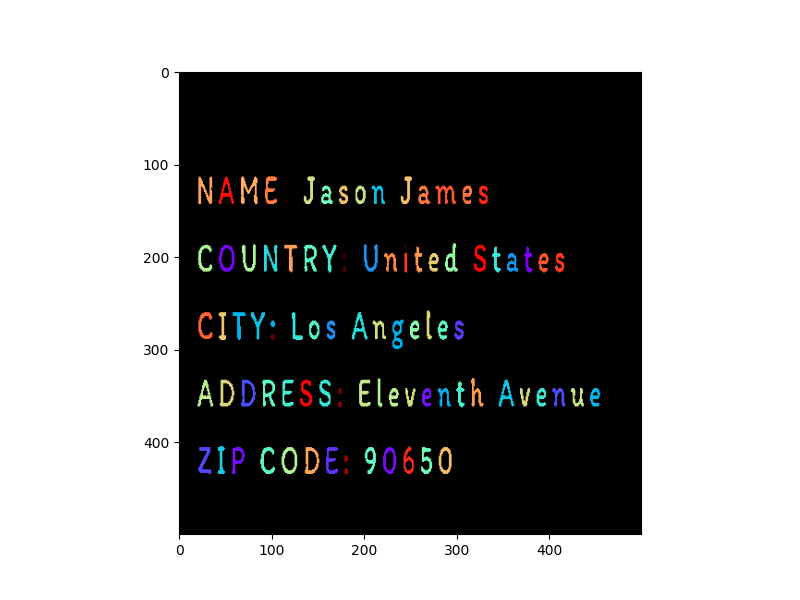

In [35]:
plt.figure(figsize=(8,6))
plt.imshow(im_out2)
plt.savefig("../imgs/results/b1_labeling.png")
plt.show()

<IPython.core.display.Javascript object>


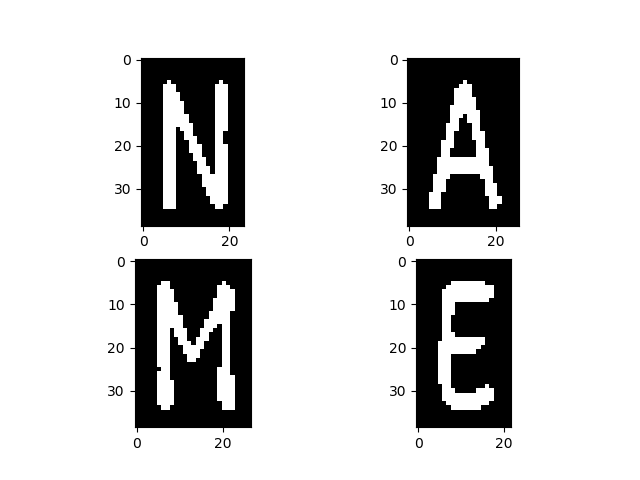

In [36]:
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(labeled_letters_sorted[0][0], cmap="gray", vmin=0, vmax=1)
ax[0,1].imshow(labeled_letters_sorted[1][0], cmap="gray", vmin=0, vmax=1)
ax[1,0].imshow(labeled_letters_sorted[2][0], cmap="gray", vmin=0, vmax=1)
ax[1,1].imshow(labeled_letters_sorted[3][0], cmap="gray", vmin=0, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


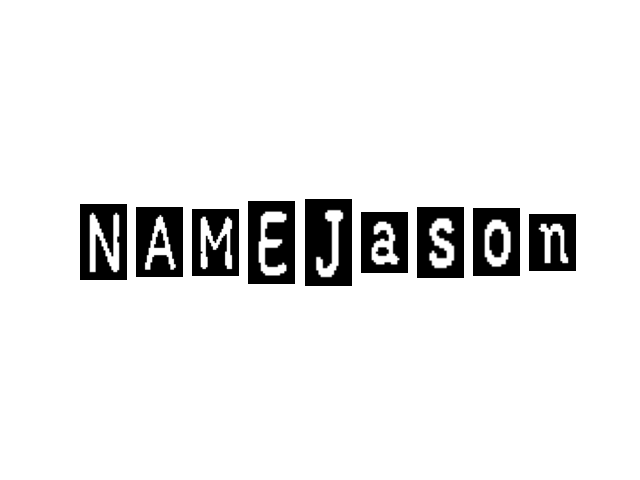

In [38]:
fig, ax = plt.subplots(1, 9)
ax[0].imshow(labeled_letters_sorted[0][0], cmap="gray", vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(labeled_letters_sorted[1][0], cmap="gray", vmin=0, vmax=1)
ax[1].axis('off')
ax[2].imshow(labeled_letters_sorted[2][0], cmap="gray", vmin=0, vmax=1)
ax[2].axis('off')
ax[3].imshow(labeled_letters_sorted[3][0], cmap="gray", vmin=0, vmax=1)
ax[3].axis('off')
ax[4].imshow(labeled_letters_sorted[4][0], cmap="gray", vmin=0, vmax=1)
ax[4].axis('off')
ax[5].imshow(labeled_letters_sorted[5][0], cmap="gray", vmin=0, vmax=1)
ax[5].axis('off')
ax[6].imshow(labeled_letters_sorted[6][0], cmap="gray", vmin=0, vmax=1)
ax[6].axis('off')
ax[7].imshow(labeled_letters_sorted[7][0], cmap="gray", vmin=0, vmax=1)
ax[7].axis('off')
ax[8].imshow(labeled_letters_sorted[8][0], cmap="gray", vmin=0, vmax=1)
ax[8].axis('off')
plt.savefig("../imgs/results/b1_charscrop.png")
plt.show()

In [39]:
labeled_letters_sorted[0][0].shape

(39, 24)

<IPython.core.display.Javascript object>


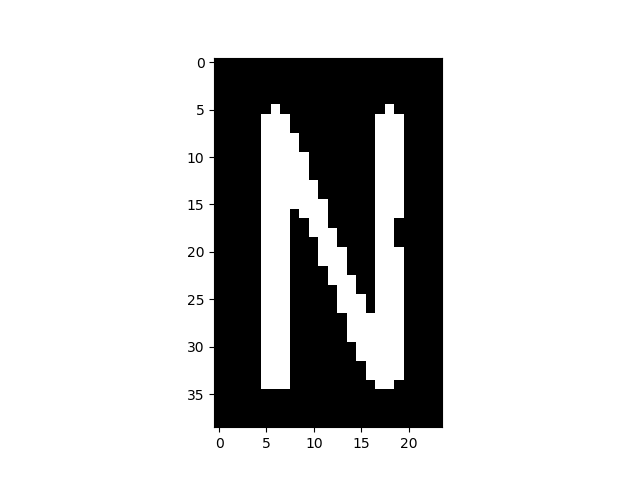

<IPython.core.display.Javascript object>


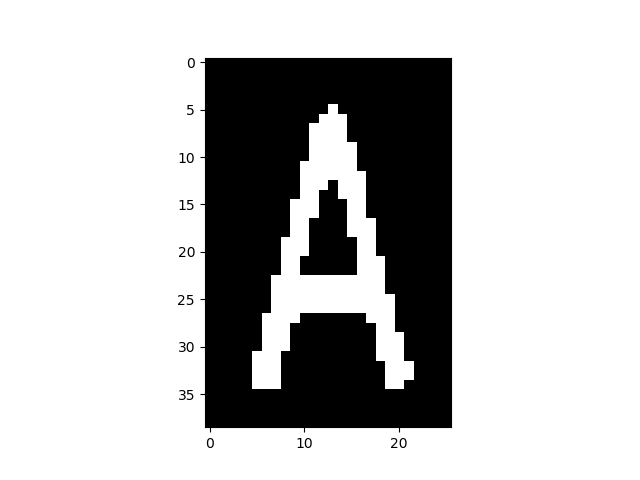

In [40]:
for ll, v0, v1 in labeled_letters_sorted[0:2]:
    plt.figure()
    plt.imshow(ll, cmap="gray", vmin=0, vmax=1)
    plt.show()